# Projet Télédétection avancée
## Pyrénées 2023-2024
### TUIL Shona 

#### Bibliothèques et fonctions utilisées

In [3]:
import os
import sys
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from osgeo import gdal, ogr
gdal.UseExceptions()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib.colors import ListedColormap

# Import libsigma
sys.path.append("/home/onyxia/work/libsigma")
from classification import get_samples_from_roi
import plots

#### Chemins

In [7]:
# données en entrée 

data = "/home/onyxia/work/data/projet_eval"

# Rasters
raster_ref = os.path.join(data, "pyrenees_23-24_B03.tif")
b3 = os.path.join(data, "pyrenees_23-24_B03.tif")
b5 = os.path.join(data, "pyrenees_23-24_B05.tif")

# Échantillons
samples = os.path.join(data, "PI_strates_pyrenees_32630.shp")

# Chemins en sortie 
OUT_DIR = "results"
FIG_DIR = os.path.join(OUT_DIR, "figure")
os.makedirs(FIG_DIR, exist_ok=True)

raster_samples = os.path.join(OUT_DIR, "raster_samples.tif")
raster_ARI = os.path.join(OUT_DIR, "ARI_serie_temp.tif")
ARI_series = os.path.join(FIG_DIR, "ARI_series_temporelles.png")

In [8]:
champ_strate = "strate"
descr_strates = {1: "Sol Nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}

dates = [
    "2023-09-25", "2023-09-30", "2023-10-05", "2023-10-07", "2023-10-10",
    "2023-10-12", "2023-11-19", "2023-12-16", "2024-01-25", "2024-03-13",
    "2024-04-12", "2024-05-09", "2024-06-13", "2024-07-23", "2024-08-22"
]

#### Analyse des échantillons

In [9]:
gdf_samples = gpd.read_file(samples)
samples_valid = gdf_samples[gdf_samples.geometry.notnull()].copy()

counts_poly = samples_valid[champ_strate].value_counts().sort_index()
df_poly = pd.DataFrame({
    "strate": counts_poly.index,
    "nb_polygones": counts_poly.values,
    "description": [descr_strates[i] for i in counts_poly.index]
})

Rasterisation et comptage des pixels

In [10]:
ref_ds = gdal.Open(raster_ref)
gt, proj = ref_ds.GetGeoTransform(), ref_ds.GetProjection()
cols, rows = ref_ds.RasterXSize, ref_ds.RasterYSize

driver = gdal.GetDriverByName("GTiff")
ds_roi = driver.Create(raster_samples, cols, rows, 1, gdal.GDT_Int32)
ds_roi.SetGeoTransform(gt)
ds_roi.SetProjection(proj)
band = ds_roi.GetRasterBand(1)
band.Fill(0)
band.SetNoDataValue(0)

vector_ds = ogr.Open(samples)
gdal.RasterizeLayer(ds_roi, [1], vector_ds.GetLayer(), options=[f"ATTRIBUTE={champ_strate}", "ALL_TOUCHED=TRUE"])
ds_roi = None

ds_strate = gdal.Open(raster_samples)
arr_strate = ds_strate.GetRasterBand(1).ReadAsArray()
ds_strate = None

strates_unique = np.unique(arr_strate[arr_strate != 0])
pixels_par_strate = {s: np.sum(arr_strate == s) for s in strates_unique}

df_pixels = pd.DataFrame({
    "strate": list(pixels_par_strate.keys()),
    "nb_pixels": list(pixels_par_strate.values()),
    "description": [descr_strates[i] for i in pixels_par_strate.keys()]
})

#### Diagrammes du nombre de polygones et du nombre de pixels par strates

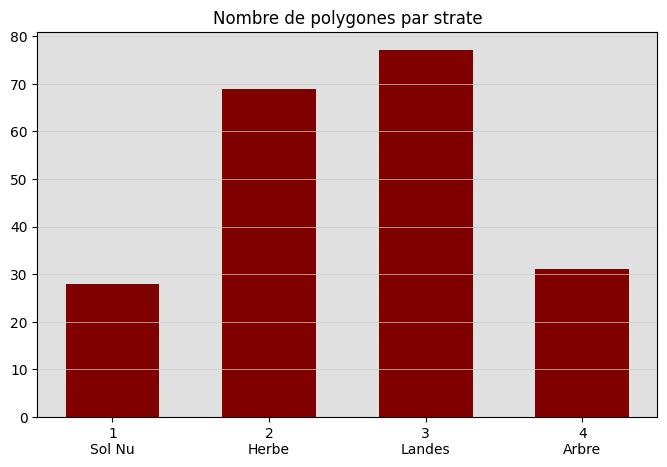

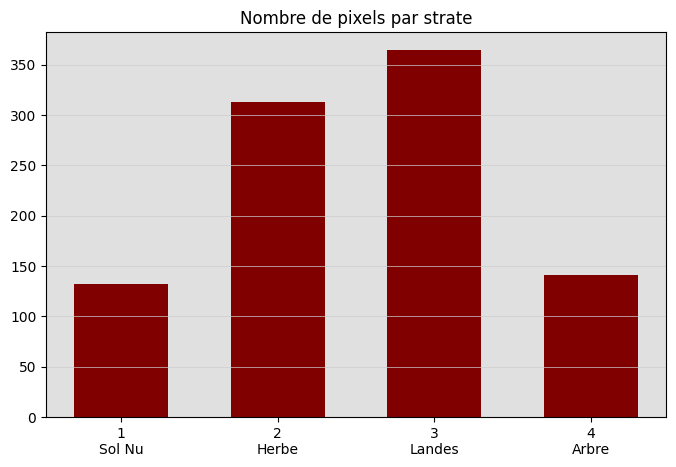

In [11]:
bar_width, facecolor_bg, bar_color = 0.6, "#e0e0e0", "#800000"
grid_color, grid_width = "#cccccc", 0.5

# Nb Polygones
fig, ax = plt.subplots(figsize=(8,5))
ax.set_facecolor(facecolor_bg)
ax.yaxis.grid(True, color=grid_color, linewidth=grid_width)
ax.bar(df_poly["strate"], df_poly["nb_polygones"], color=bar_color, width=bar_width)
ax.set_title("Nombre de polygones par strate")
ax.set_xticks(df_poly["strate"])
ax.set_xticklabels([f"{i}\n{descr_strates[i]}" for i in df_poly["strate"]])
plt.savefig(os.path.join(FIG_DIR, "diag_baton_nb_poly_by_class.png"))

# Nb Pixels
fig, ax = plt.subplots(figsize=(8,5))
ax.set_facecolor(facecolor_bg)
ax.yaxis.grid(True, color=grid_color, linewidth=grid_width)
ax.bar(df_pixels["strate"], df_pixels["nb_pixels"], color=bar_color, width=bar_width)
ax.set_title("Nombre de pixels par strate")
ax.set_xticks(df_pixels["strate"])
ax.set_xticklabels([f"{i}\n{descr_strates[i]}" for i in df_pixels["strate"]])
plt.savefig(os.path.join(FIG_DIR, "diag_baton_nb_pix_by_class.png"))
plt.show()

### Phénologie des strates, mise en évidence des landes

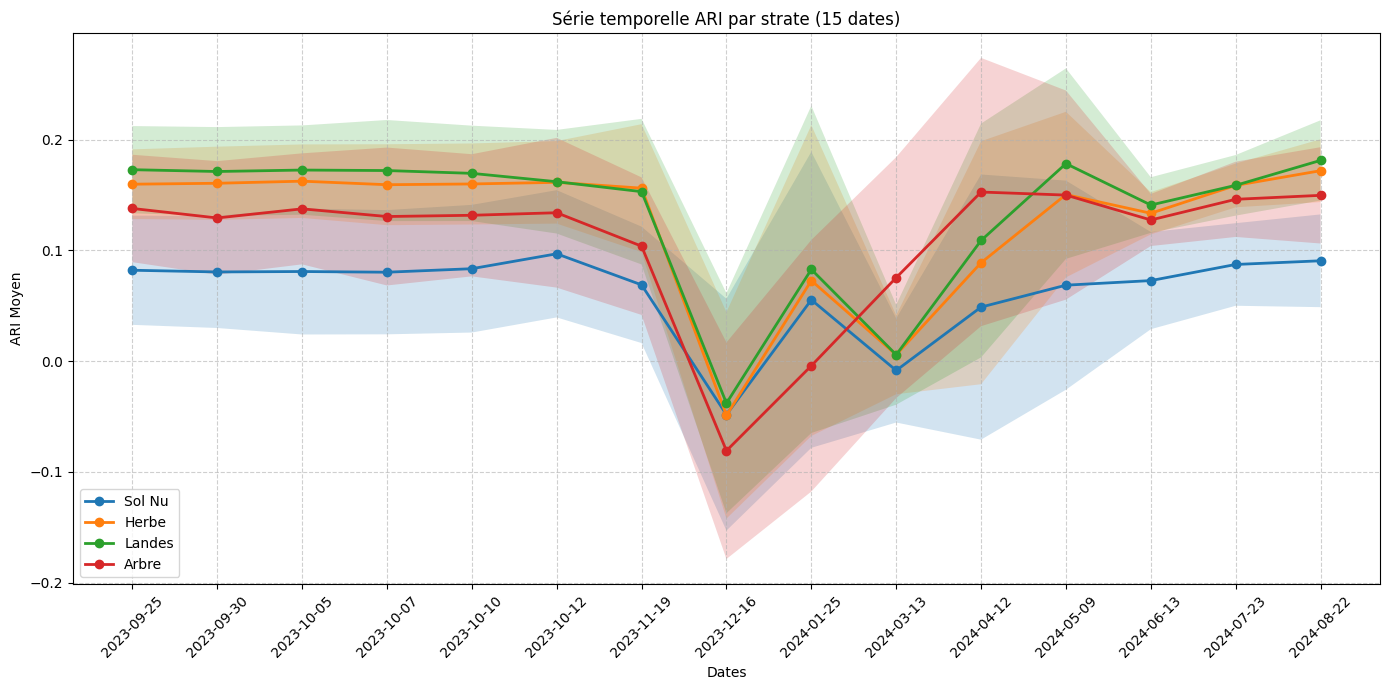

In [12]:
ds_b3 = gdal.Open(b3)
ds_b5 = gdal.Open(b5)
nb_bands = ds_b3.RasterCount

b3_cube = ds_b3.ReadAsArray().astype(np.float32)
b5_cube = ds_b5.ReadAsArray().astype(np.float32)

with np.errstate(divide='ignore', invalid='ignore'):
    inv_b3 = 1 / b3_cube
    inv_b5 = 1 / b5_cube
    ARI_cube = (inv_b3 - inv_b5) / (inv_b3 + inv_b5)

ARI_cube[np.isnan(ARI_cube)] = -9999

# Sauvegarde Raster ARI
ds_ari = driver.Create(raster_ARI, cols, rows, nb_bands, gdal.GDT_Float32)
ds_ari.SetGeoTransform(gt); ds_ari.SetProjection(proj)
for i in range(nb_bands):
    band_ari = ds_ari.GetRasterBand(i+1)
    band_ari.WriteArray(ARI_cube[i])
    band_ari.SetNoDataValue(-9999)
ds_ari = None

# Graphique ARI par strate
fig, ax = plt.subplots(figsize=(14, 7))
for c, label in descr_strates.items():
    mask = (arr_strate == c)
    if not np.any(mask): continue
    ARI_flat = ARI_cube.reshape(nb_bands, -1)
    masked_data = ARI_flat[:, mask.flatten()]
    masked_data = np.where(masked_data == -9999, np.nan, masked_data)
    mean_values = np.nanmean(masked_data, axis=1)
    std_values = np.nanstd(masked_data, axis=1)
    ax.plot(dates, mean_values, label=label, marker='o', linewidth=2)
    ax.fill_between(dates, mean_values - std_values, mean_values + std_values, alpha=0.2)

ax.set_xlabel("Dates")
ax.set_ylabel("ARI Moyen")
ax.set_title("Série temporelle ARI par strate (15 dates)")
plt.xticks(rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(ARI_series, dpi=300)
plt.show()


#### Classification RF

--- Préparation du stack multi-bandes ---
Extraction des échantillons (165 variables)...
Optimisation GridSearchCV...

SCORE GLOBAL FINAL (OA) : 0.84
              precision    recall  f1-score   support

      Sol Nu       0.95      0.82      0.88       132
       Herbe       0.78      0.90      0.84       313
      Landes       0.85      0.82      0.83       364
       Arbre       0.93      0.79      0.86       141

    accuracy                           0.84       950
   macro avg       0.88      0.83      0.85       950
weighted avg       0.85      0.84      0.84       950



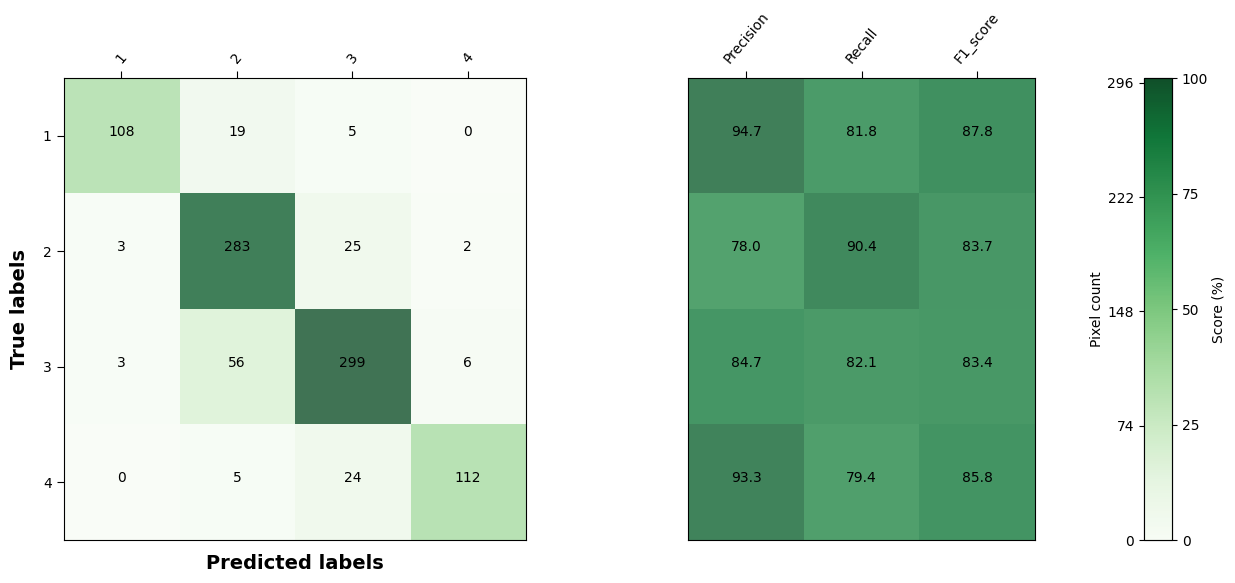

In [13]:
print("--- Préparation du stack multi-bandes ---")
bandes_s2 = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
fichiers_physiques = []
feature_names_full = []

for b in bandes_s2:
    path = os.path.join(data, f"pyrenees_23-24_{b}.tif")
    if os.path.exists(path):
        fichiers_physiques.append(path)
        for d in dates:
            feature_names_full.append(f"{b}_{d}")

if os.path.exists(raster_ARI):
    fichiers_physiques.append(raster_ARI)
    for d in dates:
        feature_names_full.append(f"ARI_{d}")

vrt_stack = os.path.join(OUT_DIR, "stack_temp.vrt")
gdal.BuildVRT(vrt_stack, fichiers_physiques, separate=True)

print(f"Extraction des échantillons (165 variables)...")
X, Y, t = get_samples_from_roi(vrt_stack, raster_samples)
Y = Y.ravel()

# Groupe ID pour validation croisée
ds_id = driver.Create("/vsimem/ids.tif", cols, rows, 1, gdal.GDT_Int32)
ds_id.SetGeoTransform(gt); ds_id.SetProjection(proj)
gdal.RasterizeLayer(ds_id, [1], vector_ds.GetLayer(), options=["ATTRIBUTE=id"])
groups = ds_id.ReadAsArray()[t].ravel()

X = np.nan_to_num(X, nan=0.0)
X[X == -9999] = 0

print("Optimisation GridSearchCV...")
cv = StratifiedGroupKFold(n_splits=5)
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 15, 20], 'max_features': ['sqrt', 'log2']}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, Y, groups=groups)

best_rf = grid_search.best_estimator_
y_pred = cross_val_predict(best_rf, X, Y, groups=groups, cv=cv)

print(f"\nSCORE GLOBAL FINAL (OA) : {accuracy_score(Y, y_pred):.2f}")
print(classification_report(Y, y_pred, target_names=[descr_strates[i] for i in np.unique(Y)]))

# Matrice de confusion
cm = confusion_matrix(Y, y_pred, labels=np.unique(Y))
plots.plot_cm(cm, np.unique(Y))
plt.savefig(os.path.join(FIG_DIR, "matrice_confusion_finale.png"))
plt.show()

Importance des variables 

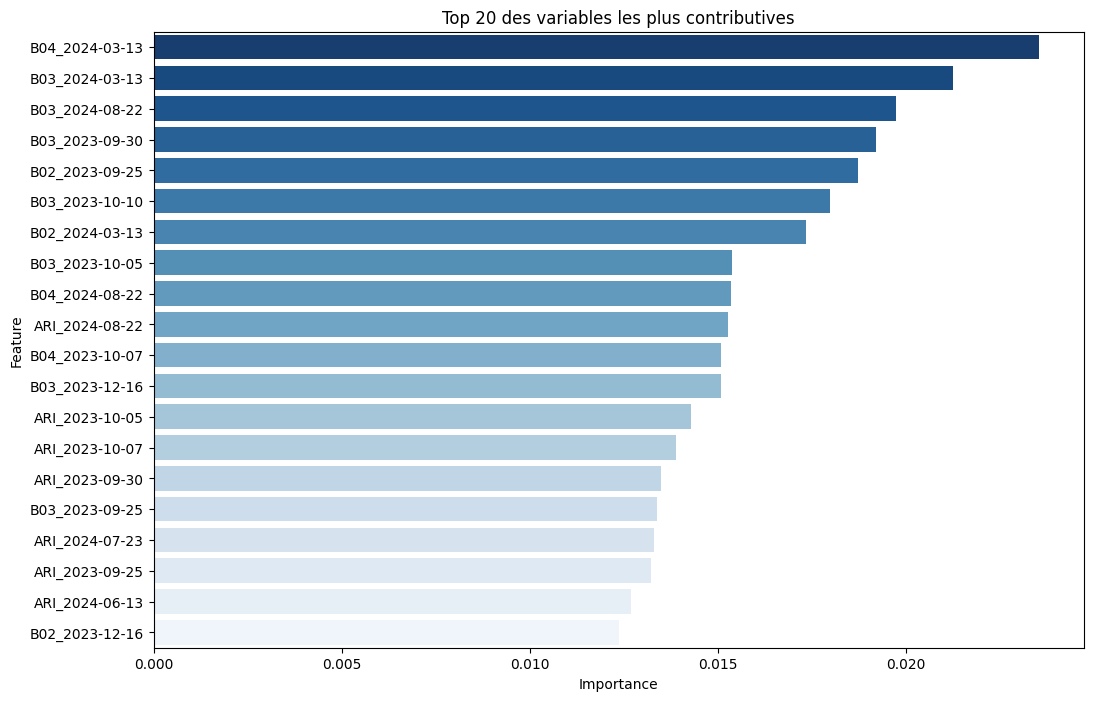

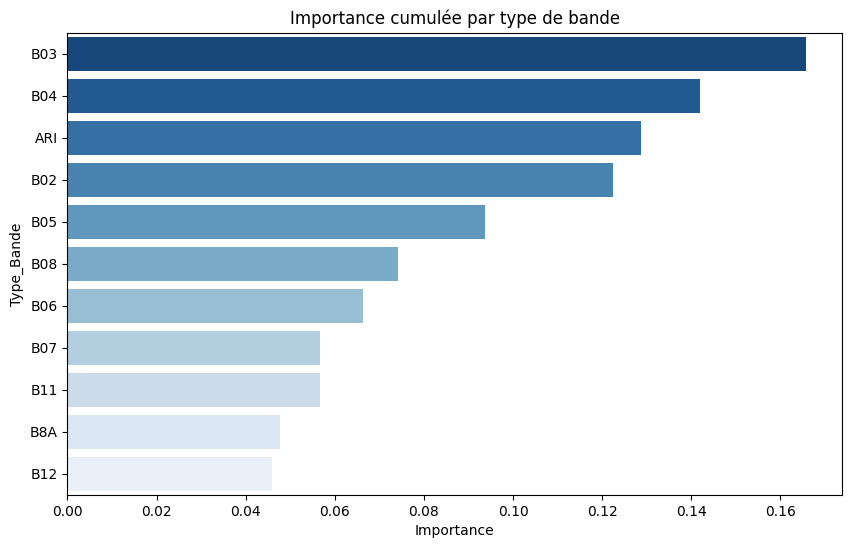

In [14]:
# Top 20 variables
df_all_imp = pd.DataFrame({'Feature': feature_names_full, 'Importance': best_rf.feature_importances_})
df_top20 = df_all_imp.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=df_top20, palette='Blues_r', hue='Feature', legend=False)
plt.title("Top 20 des variables les plus contributives")
plt.savefig(os.path.join(FIG_DIR, "importance_top20_final.png"))
plt.show()

# Synthèse par bande
df_all_imp['Type_Bande'] = df_all_imp['Feature'].apply(lambda x: x.split('_')[0])
df_synth = df_all_imp.groupby('Type_Bande')['Importance'].sum().reset_index().sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Type_Bande', data=df_synth, palette='Blues_r', hue='Type_Bande', legend=False)
plt.title("Importance cumulée par type de bande")
plt.savefig(os.path.join(FIG_DIR, "importance_synthetique_bandes.png"))
plt.show()

#### Production et affichage de la carte

Génération de la carte finale masquée...


/home/onyxia/work/libsigma/classification.py:101: RuntimeWarning: invalid value encountered in cast
  Y = ROI[t].reshape((t[0].shape[0], 1)).astype('int32')


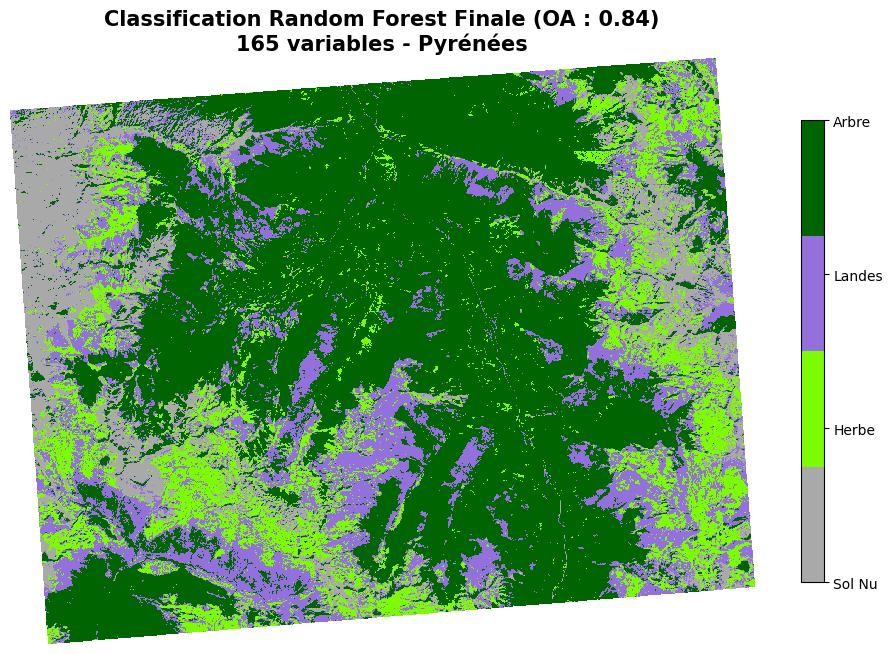

TERMINÉ ! Carte enregistrée sous : results/carte_strates_finale_pro.tif


In [15]:
print("Génération de la carte finale masquée...")

# 1. On ré-entraîne une dernière fois
best_rf.fit(X, Y)

# 2. Prédiction sur l'image complète
X_all, _, t_all = get_samples_from_roi(vrt_stack, vrt_stack)
X_all = np.nan_to_num(X_all, nan=0.0)
predictions = best_rf.predict(X_all)

# 3. Reconstruction de la carte en 2D
carte_raw = np.zeros((rows, cols), dtype=np.uint8)
carte_raw[t_all[0], t_all[1]] = predictions

# 4. Création du masque d'emprise (CORRECTION DU NOM DE VARIABLE)
ds_ref_for_mask = gdal.Open(raster_ref)
arr_ref_mask = ds_ref_for_mask.GetRasterBand(1).ReadAsArray() # Lecture de la bande 1 uniquement
ds_ref_for_mask = None 

# 5. Application du masque
carte_final_clean = np.where(arr_ref_mask > 0, carte_raw, 0)

# 6. Rendu visuel style Lisa
map_masked = np.ma.masked_where(carte_final_clean == 0, carte_final_clean)

plt.figure(figsize=(12, 10), facecolor='white')
colors = ['#A9A9A9', '#7CFC00', '#9370DB', '#006400']
custom_cmap = ListedColormap(colors)
custom_cmap.set_bad(color='white')

im = plt.imshow(map_masked, cmap=custom_cmap, vmin=1, vmax=4, interpolation='none')
cbar = plt.colorbar(im, ticks=[1, 2, 3, 4], shrink=0.6)
cbar.ax.set_yticklabels(['Sol Nu', 'Herbe', 'Landes', 'Arbre'])

plt.title(f"Classification Random Forest Finale (OA : {accuracy_score(Y, y_pred):.2f})\n165 variables - Pyrénées", 
          fontsize=15, fontweight='bold')
plt.axis('off')

plt.savefig(os.path.join(FIG_DIR, 'carte_finale_style_lisa.png'), dpi=300, bbox_inches='tight')
plt.show()

# 7. Sauvegarde du fichier TIF final
out_path_tif = os.path.join(OUT_DIR, "carte_strates_finale_pro.tif")
ds_final = driver.Create(out_path_tif, cols, rows, 1, gdal.GDT_Byte)
ds_final.SetGeoTransform(gt); ds_final.SetProjection(proj)
ds_final.GetRasterBand(1).WriteArray(carte_final_clean)
ds_final.GetRasterBand(1).SetNoDataValue(0)
ds_final = None

print(f"TERMINÉ ! Carte enregistrée sous : {out_path_tif}")
